<a href="https://colab.research.google.com/github/SayatAbdikul/animal_classification/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder


In [3]:
image_size = 240
transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
folder_path = '/content/drive/My Drive/animals-10'
dataset = ImageFolder(root=folder_path, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [4]:
class_names = dataset.classes

In [5]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

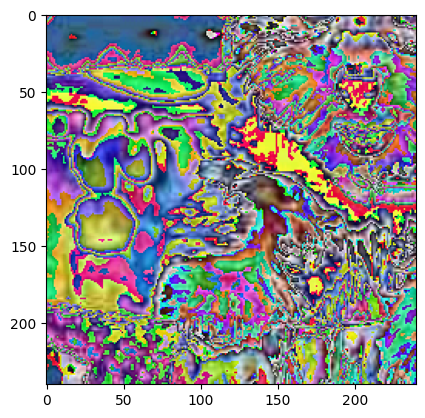

In [6]:
import matplotlib.pyplot as plt
image = next(iter(train_dataloader))[0][0]
to_pil = transforms.ToPILImage()
plt.imshow(to_pil(image))
plt.show()

# Helper functions

In [7]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> float:
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if len(X) == 0:
            print(f"empty batch on {batch}")
            continue
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 10 == 0:
          print(f"looked at batch: {batch}/ {len(dataloader)}")
    print(f"Train loss: {train_loss/len(train_dataloader):.5f} | Train accuracy: {train_acc/len(train_dataloader):.2f}%")

In [9]:
def evaluation_step(model: torch.nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    device: torch.device) -> float:
    model.eval()
    with torch.inference_mode():
        eval_loss, eval_acc = 0, 0
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            if len(X) == 0:
                print(f"empty batch on {batch}")
                continue
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item()
            eval_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        print(f"Model loss: {eval_loss/len(val_dataloader):.5f} | Model accuracy: {eval_acc/len(val_dataloader):.2f}%")

# Pre-trained B0 model

In [10]:
import torchvision
from torchvision import models
trained_model = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s]


In [11]:
from torch import nn
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=trained_model.parameters(), lr=0.1)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=trained_model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=trained_model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------


KeyboardInterrupt: 

In [ ]:
evaluation_step(model=trained_model, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

# Model



In [12]:
base_model = [
    (1, 16, 1, 1, 3),
    (6, 24, 2, 2, 3),
    (6, 40, 2, 2, 5),
    (6, 80, 3, 2, 3),
    (6, 112, 3, 1, 5),
    (6, 192, 4, 2, 5),
    (6, 320, 1, 1, 3)
]
settings = [
    # phi, resolution, drop rate
    (0, 224, 0.2),
    (0.5, 240, 0.2),
    (1, 260, 0.3),
    (2, 300, 0.3),
    (3, 380, 0.4),
    (4, 456, 0.4),
    (5, 528, 0.5),
    (6, 600, 0.5)
]

In [13]:
from torch import nn
class CNNBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int, groups=1):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    def forward(self, x):
        return self.conv(x)

In [14]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels: int, reduced_dim: int):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=in_channels, out_channels=reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(in_channels=reduced_dim, out_channels=in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    def forward(self, x):
      return x * self.se(x)

In [25]:
class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction=4,  # squeeze excitation
        survival_prob=0.8,  # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels,
                hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim,
                hidden_dim,
                kernel_size,
                stride,
                padding,
                groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


In [16]:
import math
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes: int):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = math.ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(last_channels, num_classes)
        )
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, resolution, drop_rate = settings[version]
        width_factor = alpha ** phi
        depth_factor = beta ** phi
        return width_factor, depth_factor, drop_rate
    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, 2, 1)]
        in_channels = channels
        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * math.ceil(int(channels * width_factor) / 4)
            layers_repeats = math.ceil(repeats * depth_factor)
            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(in_channels = in_channels,
                                          out_channels = out_channels,
                                          expand_ratio=expand_ratio,
                                          stride=stride if layer == 0 else 1,
                                          kernel_size=kernel_size,
                                          padding=kernel_size//2,

                                          ))
                in_channels = out_channels
        features.append(CNNBlock(in_channels, last_channels, 1, 1, 0))
        return nn.Sequential(*features)
    def forward(self, x):
      x = self.pool(self.features(x))
      return self.classifier(x.view(x.shape[0], -1)) # flattening


# EfficientNet-B0. Baseline with convolution

In [24]:
model_0 = EfficientNet(version=0, num_classes=len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
epochs = 3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_0.to(device)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(model=model_0, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    evaluation_step(model=model_0, dataloader=val_dataloader, loss_fn=loss_fn, device=device)

Epoch: 0
---------
looked at batch: 0/ 252
looked at batch: 10/ 252
looked at batch: 20/ 252
looked at batch: 30/ 252
looked at batch: 40/ 252
looked at batch: 50/ 252
looked at batch: 60/ 252
looked at batch: 70/ 252
looked at batch: 80/ 252
looked at batch: 90/ 252
looked at batch: 100/ 252
looked at batch: 110/ 252
looked at batch: 120/ 252
looked at batch: 130/ 252
looked at batch: 140/ 252
looked at batch: 150/ 252
looked at batch: 160/ 252
looked at batch: 170/ 252
looked at batch: 180/ 252
looked at batch: 190/ 252
looked at batch: 200/ 252
looked at batch: 210/ 252
looked at batch: 220/ 252
looked at batch: 230/ 252
looked at batch: 240/ 252
looked at batch: 250/ 252
Train loss: 1.38414 | Train accuracy: 48.28%
Model loss: 1.55826 | Model accuracy: 41.77%
Epoch: 1
---------
looked at batch: 0/ 252
looked at batch: 10/ 252
looked at batch: 20/ 252
looked at batch: 30/ 252
looked at batch: 40/ 252
looked at batch: 50/ 252
looked at batch: 60/ 252
looked at batch: 70/ 252
looked a

In [26]:
evaluation_step(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn, device=device)

Model loss: 1.42746 | Model accuracy: 38.01%


# EfficientNet-B1

## Creating the MBConvBlock for this model

In [ ]:
class MBConvBlock_B1(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, expansion: int):
        super(MBConvBlock_B1, self).__init__()

        self.use_residual = (in_channels == out_channels) and (stride == 1)

        hidden_dim = in_channels * expansion
        layers = []

        # Expansion phase
        if expansion != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU(inplace=True))

        # Depthwise convolution phase
        layers.append(nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False))
        layers.append(nn.BatchNorm2d(hidden_dim))
        layers.append(nn.ReLU(inplace=True))

        # Pointwise-linear phase
        layers.append(nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_residual:
            return x + self.conv(x)
        else:
            return self.conv(x)